# Sembradora 3000

It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [1]:
# Model design
import agentpy as ap
import random
import numpy as np
from collections import namedtuple, deque
from queue import PriorityQueue
from itertools import count
import math

# Visualization
import imageio
import imageio.v2 as imageio
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML

# Guardar
import pickle

# Sistema
import os

# Machine learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Grid

In [2]:
"""
0 is empty
1 is tractor
2 is obstacle
3 is target
4 is seeds
"""

def is_connected(grid, free_positions):
    """Check if all free cells are connected using BFS."""
    n = grid.shape[0]
    visited = set()
    queue = deque([free_positions.pop()])
    visited.add(queue[0])

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    connected_count = 0
    free_count = len(free_positions)

    while queue:
        x, y = queue.popleft()
        for dx, dy in directions:
            new_x, new_y = x + dx, y + dy
            if (0 <= new_x < n and 0 <= new_y < n and 
                (new_x, new_y) in free_positions and (new_x, new_y) not in visited):
                queue.append((new_x, new_y))
                visited.add((new_x, new_y))
                connected_count += 1
                
    return connected_count == free_count

def is_adjacent(pos1, pos2):
    return abs(pos1[0] - pos2[0]) <= 1 and abs(pos1[1] - pos2[1]) <= 1

def generate_grid(model, n, obstacles_count, crops_count):
    """Generate a grid with obstacles, ensuring free cells are connected."""
    while True:
        grid = ap.Grid(model, (n, n), track_empty=True)
        grid.add_field("occupied", 0)

        obstacle_positions = set()
        while len(obstacle_positions) < obstacles_count:
            pos = (random.randint(0, n-1), random.randint(0, n-1))
            if pos not in obstacle_positions:
                # Check if pos is adjacent to any seed position
                is_valid = True
                for seed_pos in model.p.seedsPositions:
                    if is_adjacent(pos, seed_pos):
                        is_valid = False
                        break
                if is_valid:
                    obstacle_positions.add(pos)

        for pos in obstacle_positions:
            grid["occupied"][pos] = 1

        free_positions = {(x, y) for x in range(n) for y in range(n) if grid["occupied"][x, y] == 0}
        
        if is_connected(grid, free_positions):
            break

    for pos in obstacle_positions:
        grid["occupied"][pos] = 1
        model.np_grid[pos] = 2
        
        crops_positions = set()
        while len(crops_positions) < crops_count:
            pos = (random.randint(0, n-1), random.randint(0, n-1))
            if pos not in obstacle_positions and pos not in crops_positions:
                crops_positions.add(pos)
                model.np_grid[pos] = 3

    agentlist = ap.AgentList(model, len(obstacle_positions), agent_type=2)
    grid.add_agents(agentlist, obstacle_positions)
    
    model.grid = grid
    
    return obstacle_positions, crops_positions

## Agente

In [3]:
class CollectingTractor(ap.Agent):
    def setup(self):
        """Initialize agent parameters."""
        self.initialized = False
        self.reset()

    def reset(self):
        """Reset agent attributes."""
        if not self.initialized:
            self._initialize_agent()
        else:
            self._restore_agent()

    def _initialize_agent(self):
        """Initialize the agent's initial state."""
        self.planted = 0
        self.destroyed = False
        self.seeds = 0
        self.type = 1
        self.pos = (0, 0)
        self.new_pos = (0, 0)
        self.visited_positions = set()
        self.cell_state = 0  

        num_cell_states = 3

        # Initialize Q-learning parameters
        self.q_table = np.zeros((self.p.grid_size, self.p.grid_size, self.p.capacity + 1, num_cell_states, 6))
        self.learning_rate = self.p.learning_rate
        self.discount_factor = self.p.discount_factor
        self.epsilon = self.p.epsilon

        self.initialized = True  # Mark as initialized

    def _restore_agent(self):
        """Restore the agent's state to its initial conditions."""
        self.planted = 0
        self.targetIndex = 1
        self.destroyed = False
        self.seeds = 0
        self.type = 1
        self.pos = (0, 0)
        self.visited_positions = set()
        self.cell_state = 0
        
        num_cell_states = 3

        # Initialize Q-learning parameters
        self.q_table = np.zeros((self.p.grid_size, self.p.grid_size, self.p.capacity + 1, num_cell_states, 6))
        self.learning_rate = self.p.learning_rate
        self.discount_factor = self.p.discount_factor
        self.epsilon = self.p.epsilon
        
    def setCellState(self, pos):
        if self.model.np_grid[pos] == 3:
            self.cell_state = 0
        elif self.model.np_grid[pos] == 4:
            self.cell_state = 1
        else:
            self.cell_state = 2
    
    def destroyed(self):
        self.pos = (None, None)
        
    def setNewPositionVerify(self, pos):
        self.new_pos = pos
        
    def move(self, agentes, dx=0, dy=0):
        """Move the tractor by (dx, dy)."""
        x, y = self.pos
        new_pos = (x + dx, y + dy)

        # Asegúrate de que la nueva posición está dentro de los límites de la cuadrícula
        if 0 <= new_pos[0] < self.p.grid_size and 0 <= new_pos[1] < self.p.grid_size:
            # Verifica si la nueva posición no es un obstáculo
            if self.model.np_grid[new_pos] != 2 and new_pos != self.p.seedsPositions[0]:
                # Verifica si algún otro agente ya tiene la nueva posición como su siguiente posición
                self.setNewPositionVerify(new_pos)
                for agente in agentes:
                    if agente is not self:
                        if agente.new_pos == new_pos:
                            return self.pos, False  # No se puede mover porque la posición está ocupada por otro agente
                # Si no hay obstáculos ni agentes en la nueva posición, se mueve
                self.pos = new_pos
                self.setCellState(self.pos)
                return self.pos, True
        return self.pos, False  # No se puede mover porque está fuera de los límites o hay un obstáculo

    def move_up(self, agents):
        return self.move(agents, dy=1)

    def move_down(self, agents):
        return self.move(agents, dy=-1)

    def move_left(self, agents):
        return self.move(agents, dx=-1)

    def move_right(self, agents):
        return self.move(agents, dx=1)

    def drop(self, agents):
        """Drop seeds at the current target position."""
        if self.seeds > 0 and self.pos and self.model.np_grid[self.pos] == 3:
            self.seeds -= 1
            # Remove target from grid
            self.model.np_grid[self.pos] = 0
            self.planted += 1
            return self.pos, True
        else:
            return self.pos, False

    def collect(self, agents):
        """Collect seeds if available at the surrounding positions, including diagonals."""
        # Verificar si el agente está en alguna de las celdas adyacentes
        if self.pos in self.model.neighbors:
            if self.seeds == 0:
                self.seeds = self.capacity
                return self.pos, 1
            elif self.seeds > 0 and self.seeds < self.capacity:
                self.seeds = self.capacity
                return self.pos, 2

        # Si el agente no está en ninguna celda adyacente a seedsPositions
        return self.pos, 3
    
    def exit(self, agents):
        x, y = self.pos

        # Verifica si el agente ya está en el borde del grid
        if self.pos in self.model.neighbors:
            self.destroyed = True
            return self.pos, True  
        else:
            return self.pos, False  


    def get_reward(self, action, accionado):
        """Calculate the reward based on the action and outcome."""
        reward = 0  # No base penalty for movement

        if action in [0, 1, 2, 3]:  # Movement actions
            if accionado:
                reward += -5
            else:
                reward += -3 # Strong penalty for hitting an obstacle or invalid move
        elif action == 4:  # Drop seeds
            if accionado:
                reward += 150
            else:   
                reward += -5
        elif action == 5:  # Collect seeds
            if accionado == 1: # Si no tiene semillas
                reward += 10
            elif accionado == 2: # Si tiene semillas pero no está lleno
                reward += -5
            else: # Si no está en ninguna celda adyacente a seedsPositions
                reward += -10

        # Reward for exploring new positions
        if self.pos not in self.visited_positions:
            reward += 5
            self.visited_positions.add(self.pos)
        
        return reward
    
    # Función auxiliar para obtener el Q-value considerando celdas adyacentes
    def get_neighbor_q_value(self, x, y, seeds, cell, action):
        q_value = self.q_table[x, y, seeds, cell, action]
        # Incluye los valores Q de las celdas adyacentes
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.p.grid_size and 0 <= ny < self.p.grid_size:
                q_value += self.q_table[nx, ny, seeds, cell, action]
        return q_value / 5  # Promedio del valor Q del estado actual y sus adyacentes
        
    def q_learning_update(self, state, action, reward, next_state):
        x, y, seeds, cell = state
        next_x, next_y, next_seeds, next_cell = next_state

        # Q-value actual considerando las celdas adyacentes
        current_q = self.get_neighbor_q_value(x, y, seeds, cell, action)
        # Max Q-value del siguiente estado
        max_next_q = np.max(self.q_table[next_x, next_y, next_seeds, next_cell])

        # Actualizar el valor Q
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[x, y, seeds, cell, action] = new_q
        
        if self.destroyed:
            self.destroyed()

    def acciones(self, action, agents):
        """Map action to the corresponding method."""
        action_map = {
            0: self.move_up,
            1: self.move_down,
            2: self.move_left,
            3: self.move_right,
            4: self.drop,
            5: self.collect,
        }
        accion = action_map[action]
        return accion(agents)

    def step(self, agents):
        """Execute a step in the agent's behavior."""
        self.planted = 0
        if self.destroyed:
            return
            
        # Definir el estado actual
        state = (self.pos[0], self.pos[1], self.seeds, self.cell_state)
        
        # Acción seleccionada usando epsilon-greedy
        if np.random.rand() < self.epsilon:
            action = np.random.choice([0, 1, 2, 3, 4, 5])
        else:
            # Considerar el valor Q del estado actual y las celdas adyacentes
            q_values = []
            for action in range(6):
                q_values.append(self.get_neighbor_q_value(state[0], state[1], state[2], state[3], action))
            action = np.argmax(q_values)  # Seleccionar la acción con el Q-value más alto
            
        # Ejecutar la acción y actualizar la Q-table
        next_state, accionado = self.acciones(action, agents)
        next_cell_state = self.cell_state # Actualiza el estado de la celda después de la acción
        next_seeds = self.seeds  # Actualiza la cantidad de semillas después de la acción
        
        # Asegúrate de que next_state esté dentro de los límites
        next_state = (next_state[0], next_state[1], next_seeds, next_cell_state)
        reward = self.get_reward(action, accionado)
        self.q_learning_update(state, action, reward, next_state)
            
        # Plantado
        planted = self.planted
        
        return reward, planted

    def get_grid_aware_state(self):
        """Get the agent's state including grid awareness."""
        grid_aware_state = []
        
        # Añade información sobre las celdas adyacentes
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            adj_x, adj_y = self.pos[0] + dx, self.pos[1] + dy
            if 0 <= adj_x < self.p.grid_size and 0 <= adj_y < self.p.grid_size:
                grid_aware_state.append(self.model.np_grid[adj_x, adj_y])
            else:
                grid_aware_state.append(-1)  # Celda fuera de límites

        return tuple(grid_aware_state)


## Ambiente

In [4]:
class TractorModel(ap.Model):
    def setup(self):
        """Initialize the environment and generate coordinates."""
        self.initialized = False
        self.reset()

    def reset(self):
        """Reset or initialize the model state."""
        if not self.initialized:
            self._initialize_environment()
        else:
            self._restore_environment()

        self.steps = 0  # Reset the step counter

    def _initialize_environment(self):
        """Initialize the environment, agents, and their targets."""
        self.steps = 0
        self.max_steps = self.p.max_steps
        self.np_grid = np.zeros((self.p.grid_size, self.p.grid_size))

        # Generate and store obstacle positions
        obastacle_pos, crop_pos = generate_grid(self, self.p.grid_size, self.p.obstacles_count, self.p.crops_count)
        self.obstacle_positions = np.copy(self.grid["occupied"])
        self.crops_pos = crop_pos   
        
        # Create agents and assign initial properties
        self.agents = ap.AgentList(self, self.p.number_of_tractors, CollectingTractor)
        self._initialize_agents(obastacle_pos, crop_pos)

        self.grid.add_agents(self.agents, [tractor.pos for tractor in self.agents])
        
        for seed in self.p.seedsPositions:
            self.np_grid[seed] = 4
            
        x, y = self.p.seedsPositions[0]
        self.neighbors = [
            (x-1, y), (x+1, y), (x, y-1), (x, y+1),  
            (x-1, y-1), (x-1, y+1), (x+1, y-1), (x+1, y+1)  
        ]
        
        for pos in self.neighbors:
            self.np_grid[pos] = 0
        
        self.initialized = True  # Mark as initialized
        
    def _restore_environment(self):
        """Restore the environment to its initial state."""
        self.steps = 0
        self.max_steps = self.p.max_steps
        self.np_grid = np.zeros((self.p.grid_size, self.p.grid_size))
        
        # Restore obstacle positions
        for x in range(self.p.grid_size):
            for y in range(self.p.grid_size):
                if self.obstacle_positions[x, y] == 1:
                    self.np_grid[x, y] = 2 
        
        # Restore crop positions
        for pos in self.crops_pos:
            self.np_grid[pos] = 3
            
        self.agents.capacity = self.p.capacity
        self.agents.seeds = self.p.starting_seeds
        self.agents.destroyed = False
        # Asignar las posiciones a los tractores
        for tractor, position in zip(self.agents, self.p.tractor_positions):
            tractor.pos = position
            
        self.grid.add_agents(self.agents, [tractor.pos for tractor in self.agents])
        
        # Give positions to agents by 
        
        
        for seed in self.p.seedsPositions:
            self.np_grid[seed] = 4
            
        x, y = self.p.seedsPositions[0]
        self.neighbors = [
            (x-1, y), (x+1, y), (x, y-1), (x, y+1),  
            (x-1, y-1), (x-1, y+1), (x+1, y-1), (x+1, y+1)  
        ]
        
        for pos in self.neighbors:
            self.np_grid[pos] = 0

    def _initialize_agents(self, obstacle_pos, crop_pos):
        """Initialize agents with positions and targets."""
        self.agents.capacity = self.p.capacity
        self.agents.seeds = self.p.starting_seeds
        self.agents.destroyed = False
        # Asignar las posiciones a los tractores
        for tractor, position in zip(self.agents, self.p.tractor_positions):
            tractor.pos = position

        self.coordsUsed = set()
        self.coordsUsed.update(obstacle_pos)
        self.coordsUsed.update(crop_pos)
        self.targets_by_tractor = []
        
    def _get_free_position(self):
        """Get a free position on the grid."""
        while True:
            x, y = random.randint(0, self.p.grid_size - 1), random.randint(0, self.p.grid_size - 1)
            if self.grid["occupied"][(x, y)] == 0 and (x, y) not in self.coordsUsed and (x, y) != (0, 0):
                return (x, y)

    def step(self):
        total_reward = 0
        total_planted = 0
         # Filtra los tractores activos
        active_tractors = [tractor for tractor in self.agents if not tractor.destroyed]
        
        for tractor in active_tractors:
            reward, planted = tractor.step(self.agents)
            total_reward += reward
            total_planted += planted
        if self.steps >= self.max_steps:
            for tractor in self.agents:
                tractor.destroyed = True
            self.end()
        self.steps += 1
        return total_reward, total_planted

    def end(self):
        self.report('Total targets', self.agents.collected)


## Animation

In [5]:
"""
0 is empty
1 is tractor
2 is obstacle
3 is target
4 is seeds
"""

# Load images
tractor_img = mpimg.imread('tractor.png')
obstacle_img = mpimg.imread('obstacle.png')
target_img = mpimg.imread('target.png')
seeds_img = mpimg.imread('seeds.png')
empty_img = mpimg.imread('empty.png')

def save_frame(model, filename, total_reward):
    fig, ax = plt.subplots()
    # Clear the axis to avoid over-plotting
    ax.clear()

    # Plot the grid using images
    for (x, y), value in np.ndenumerate(model.np_grid):
        if value == 2:  # Obstacle
            ax.imshow(obstacle_img, extent=[y, y+1, x, x+1], aspect='auto')
        elif value == 3:  # Target
            ax.imshow(target_img, extent=[y, y+1, x, x+1], aspect='auto')
        elif value == 4:  # Seeds
            ax.imshow(seeds_img, extent=[y, y+1, x, x+1], aspect='auto')
        else:
            ax.imshow(empty_img, extent=[y, y+1, x, x+1], aspect='auto')
            
    # Add text for each tractor displaying the number of seeds it has
    for agent in model.agents:
        if agent.destroyed:
            continue
        ax.imshow(tractor_img, extent=[agent.pos[1], agent.pos[1]+1, agent.pos[0], agent.pos[0]+1], aspect='auto')
        ax.text(agent.pos[1] + 0.5, agent.pos[0] + 0.5, str(agent.seeds),
                color='black', fontsize=12, ha='center', va='center', weight='bold')

    # Fix axis limits based on the grid dimensions
    ax.set_xlim([0, model.np_grid.shape[1]])
    ax.set_ylim([0, model.np_grid.shape[0]])

    # Set aspect ratio to 'equal' to prevent image stretching
    ax.set_aspect('equal')

    # Set the title for the plot
    ax.set_title(f"Tractor model \n Time-step: {model.steps} - Total reward: {total_reward}")

    # Save the frame
    plt.savefig(filename)
    plt.close()

def create_gif(filenames, gif_filename):
    with imageio.get_writer(gif_filename, mode='I', duration=0.1) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
def delete_temp_frames(prefix):
    for filename in os.listdir():
        if prefix in filename:
            os.remove(filename)

## Parameters

In [6]:
def calculate_crops_count(grid_size, obstacles_count):
    return grid_size**2 - obstacles_count

tractorParameters = { # NO MOVER NINGÚN PARÁMETRO
    'grid_size': 12,
    'obstacles_count': 7,
    'number_of_tractors': 4,
    'tractor_positions': [(4, 5), (5, 4), (6, 5), (5, 6)],
    'max_steps': 800,
    'seedsPositions': [(5, 5)],
    'capacity': 3,
    'starting_seeds': 3,
    'learning_rate': 0.9, # No mover
    'discount_factor': 0.9, # No mover
    'epsilon': 1.0,
    'crops_count': calculate_crops_count(12, 7)  
}

## Machine Learning

In [7]:
# Parámetros
rewards_per_episode = []
epsilon_values = []
planting_per_episode = []

# Inicializar el modelo
model = TractorModel(tractorParameters)
model.setup()

num_episodes = 200000

def run_episode(episode, save_gif=False):
    model.reset()
    total_reward = 0
    total_planted = 0

    limited_episodes = 0.0 * num_episodes
    # Configura epsilon basado en el progreso de los episodios
    if episode == num_episodes - 1:
        epsilon = 0
    # 20% del totla de episodios
    elif episode < limited_episodes:
        epsilon = 1
    else:
        epsilon_start = 0.9  # Valor inicial de epsilon
        epsilon_end = 0.0    # Valor final de epsilon, no cero
        epsilon_decay_rate = epsilon_start - epsilon_end
        epsilon = max(epsilon_end, epsilon_start - (epsilon_decay_rate * episode / num_episodes))

    
    for tractor in model.agents:
        tractor.epsilon = epsilon

    filenames = []
    while model.steps < model.max_steps:
        reward, planted = model.step()  # Ejecutar un paso en el modelo
        total_reward += reward
        total_planted += planted
        
        if all([tractor.destroyed for tractor in model.agents]):
            break

        if save_gif:
            filename = f'frame_{model.steps}.png'
            save_frame(model, filename, total_reward)
            filenames.append(filename)
    
    if save_gif:
        gif_filename = '1rstSimulacionTractores.gif' if episode == 0 else 'lastSimulacionTractores.gif'
        create_gif(filenames, gif_filename)
        delete_temp_frames('frame')

    return total_reward, epsilon, total_planted

for episode in range(num_episodes):
    save_gif = (episode == 0 or episode == num_episodes - 1)
    total_reward, epsilon, total_planted = run_episode(episode, save_gif)
    
    rewards_per_episode.append(total_reward)
    epsilon_values.append(epsilon)
    planting_per_episode.append(total_planted)

    # Monitorear el progreso cada 10 episodios
    if episode == num_episodes - 1 or episode % 100 == 0:
        print(f'Episodio {episode + 1}/{num_episodes}, Recompensa total: {total_reward:.2f}, Epsilon: {epsilon:.2f}, Plantados: {total_planted:.2f}')
        
# Guardar cada tabla Q en un archivo con distintos nombres
for i, tractor in enumerate(model.agents):
    with open(f'q_table_{i}.pkl', 'wb') as f:
        pickle.dump(tractor.q_table, f)

print("Tabla Q guardada exitosamente en 'q_table_final.pkl'")


Episodio 1/200000, Recompensa total: -7616.00, Epsilon: 0.90, Plantados: 51.00
Episodio 101/200000, Recompensa total: -5386.00, Epsilon: 0.90, Plantados: 79.00
Episodio 201/200000, Recompensa total: -4537.00, Epsilon: 0.90, Plantados: 84.00
Episodio 301/200000, Recompensa total: -5468.00, Epsilon: 0.90, Plantados: 77.00
Episodio 401/200000, Recompensa total: -3380.00, Epsilon: 0.90, Plantados: 91.00
Episodio 501/200000, Recompensa total: -5259.00, Epsilon: 0.90, Plantados: 79.00
Episodio 601/200000, Recompensa total: -3319.00, Epsilon: 0.90, Plantados: 91.00
Episodio 701/200000, Recompensa total: -2026.00, Epsilon: 0.90, Plantados: 99.00
Episodio 801/200000, Recompensa total: -3932.00, Epsilon: 0.90, Plantados: 86.00
Episodio 901/200000, Recompensa total: -2923.00, Epsilon: 0.90, Plantados: 94.00
Episodio 1001/200000, Recompensa total: -3911.00, Epsilon: 0.90, Plantados: 88.00
Episodio 1101/200000, Recompensa total: -2588.00, Epsilon: 0.90, Plantados: 97.00
Episodio 1201/200000, Recomp

Pendiente de la línea de tendencia (Recompensas): -0.02627023452382777
Pendiente de la línea de tendencia (Plantación): -0.00018541709803271698
Media de plantación de semillas: 97.89071


C:\Users\ernes\AppData\Local\Temp\ipykernel_7552\4195350372.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(len(rewards_per_episode)), p_rewards(range(len(rewards_per_episode))), "r--", label='Trend Line', color=color_trend_line)
C:\Users\ernes\AppData\Local\Temp\ipykernel_7552\4195350372.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(len(smoothed_planting)), p_planting(range(len(smoothed_planting))), "r--", label='Trend Line', color=color_trend_line)


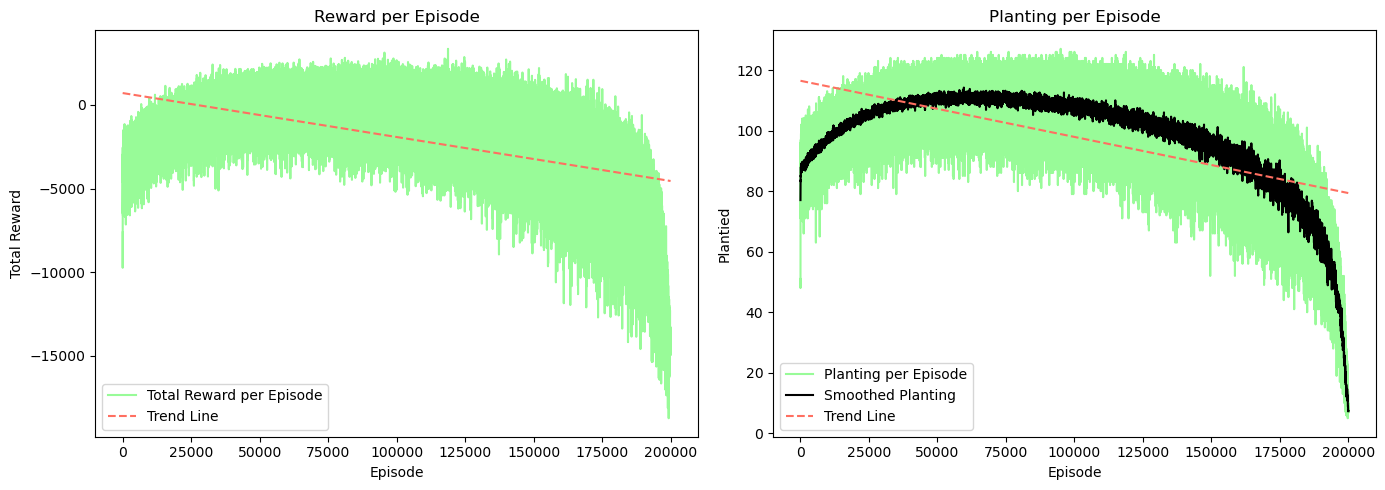

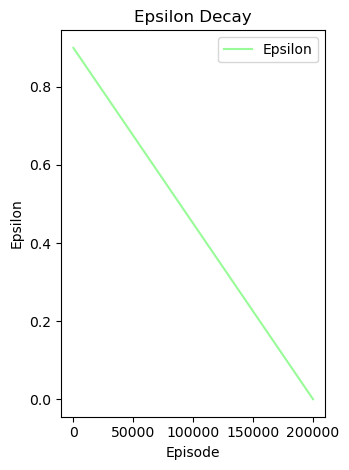

In [8]:
# Suponiendo que 'rewards_per_episode' y 'planting_per_episode' son listas o arrays con los valores correspondientes
rewards_per_episode = np.array(rewards_per_episode)  # Asegúrate de que sea un array de NumPy
planting_per_episode = np.array(planting_per_episode)  # Asegúrate de que sea un array de NumPy

# Colores de moda para 2024
color_reward = '#98FB98'  # Verde menta
color_trend_line = '#FF6F61'  # Coral
color_smoothed_planting = '#000'  # Lavanda

# Ajustar una línea recta (polinomio de grado 1) a los datos de recompensas
z_rewards = np.polyfit(range(len(rewards_per_episode)), rewards_per_episode, 1)
p_rewards = np.poly1d(z_rewards)

print(f"Pendiente de la línea de tendencia (Recompensas): {z_rewards[0]}")


# Crear la gráfica de recompensas
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode, label='Total Reward per Episode', color=color_reward)
plt.plot(range(len(rewards_per_episode)), p_rewards(range(len(rewards_per_episode))), "r--", label='Trend Line', color=color_trend_line)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.legend()

# Suavizar la serie de datos de plantación de semillas utilizando un promedio móvil
window_size = 50  # Tamaño de la ventana para el promedio móvil
smoothed_planting = np.convolve(planting_per_episode, np.ones(window_size)/window_size, mode='valid')

# Ajustar una línea recta (polinomio de grado 1) a los datos de plantación suavizados
z_planting = np.polyfit(range(len(smoothed_planting)), smoothed_planting, 1)
p_planting = np.poly1d(z_planting)

print(f"Pendiente de la línea de tendencia (Plantación): {z_planting[0]}")
print(f"Media de plantación de semillas: {np.mean(planting_per_episode)}")


# Crear la gráfica de plantación de semillas
plt.subplot(1, 2, 2)
plt.plot(planting_per_episode, label='Planting per Episode', color=color_reward)
plt.plot(range(len(smoothed_planting)), smoothed_planting, label='Smoothed Planting', color=color_smoothed_planting)
plt.plot(range(len(smoothed_planting)), p_planting(range(len(smoothed_planting))), "r--", label='Trend Line', color=color_trend_line)
plt.xlabel('Episode')
plt.ylabel('Plantied')
plt.title('Planting per Episode')
plt.legend()

plt.tight_layout()
plt.show()


# Epsilon
plt.subplot(1, 2, 1)
plt.plot(epsilon_values, label='Epsilon', color=color_reward)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')
plt.legend()

plt.tight_layout()
plt.show()

## Red Neuronal

In [9]:
# Preparar los datos para el entrenamiento
def prepare_data(q_table):
    state_size = q_table.shape[0]  # grid_size
    capacity_size = q_table.shape[2]  # capacity + 1
    num_cell_states = q_table.shape[3]  # num_cell_states
    action_size = q_table.shape[4]  # number of actions

    X_train = []
    y_train = []

    for x in range(state_size):
        for y in range(state_size):
            for seeds in range(capacity_size):
                for cell in range(num_cell_states):
                    q_values = q_table[x, y, seeds, cell, :]
                    for action in range(action_size):
                        state = np.array([x, y, seeds, cell, action])
                        X_train.append(state)
                        y_train.append(q_values[action])

    return np.array(X_train), np.array(y_train)

def complete_q_table(model, q_table):
    state_size = q_table.shape[0]  # grid_size
    capacity_size = q_table.shape[2]  # capacity + 1
    num_cell_states = q_table.shape[3]  # num_cell_states
    action_size = q_table.shape[4]  # number of actions

    q_table_completed = np.copy(q_table)

    for x in range(state_size):
        for y in range(state_size):
            for seeds in range(capacity_size):
                for cell in range(num_cell_states):
                    if np.all(q_table[x, y, seeds, cell, :] == 0):  # Solo completa si todos los valores están en cero
                        state = np.array([x, y, seeds, cell])
                        X = np.concatenate([np.tile(state, (action_size, 1)), np.arange(action_size).reshape(-1, 1)], axis=1)
                        
                        q_values_predicted = model.predict(X)
                        q_table_completed[x, y, seeds, cell, :] = q_values_predicted.mean(axis=0)

    return q_table_completed

In [10]:
for i in range(4):
    with open(f'q_table_{i}.pkl', 'rb') as f:
        q_table = pickle.load(f)

    X_train, y_train = prepare_data(q_table)

    # Paso 2: Definir y entrenar la red neuronal
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(q_table.shape[4], activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=1000, verbose=1)
    
    q_table_completed = complete_q_table(model, q_table)

    # Guardar la Q-table completada
    with open(f'q_table_completed{i}.pkl', 'wb') as f:
        pickle.dump(q_table_completed, f)

    print(f"Q-table completada guardada exitosamente en 'q_table_completed{i}.pkl'")

Epoch 1/1000


## Simulación Final

In [ ]:
# Inicializar el modelo
model.reset()

epsilon = 0
for tractor in model.agents:
        tractor.epsilon = epsilon
        
for tractor in model.agents:
    with open(f'q_table_completed{i}.pkl', 'rb') as f:
        tractor.q_table = pickle.load(f)

rewards_per_episode = []
epsilon_values = []
planting_per_episode = []
filenames = []
while model.steps < model.max_steps:
        reward, planted = model.step()  # Ejecutar un paso en el modelo
        total_reward += reward
        total_planted += planted

        if all([tractor.destroyed for tractor in model.agents]):
                break

        filename = f'frame_{model.steps}.png'
        save_frame(model, filename, total_reward)
        filenames.append(filename)

        print(f"Numero de pasos: {model.steps}")
        print(f"Recompensa total: {total_reward:.2f}, Plantados: {total_planted:.2f}")

gif_filename = 'simulacionFinal.gif' 
create_gif(filenames, gif_filename)
delete_temp_frames('frame')

print("Simulación final guardada exitosamente en 'simulacionFinal.gif'")